In [3]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# import the image net data set 
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

URL transformed to HTTPS due to an HSTS policy
--2024-12-08 18:12:20--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  9.27MB/s    in 28s     

2024-12-08 18:12:50 (8.34 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [14]:
import zipfile
import os

# Specify the path to the ZIP file
zip_file_path = 'dl/tiny-imagenet-200.zip'

# Specify the directory where the contents will be extracted
extract_to_path = 'dl'

# Check if the ZIP file exists
if os.path.exists(zip_file_path):
    # Open the ZIP file in read mode
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents to the specified directory
        zip_ref.extractall(extract_to_path)
        print(f"Files extracted to: {extract_to_path}")
else:
    print(f"The file {zip_file_path} does not exist!")


Files extracted to: dl


In [16]:
!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 8.3 MB 3.0 MB/s            
     |████████████████████████████████| 1.6 MB 62.6 MB/s            
     |████████████████████████████████| 321 kB 66.7 MB/s            
     |████████████████████████████████| 4.6 MB 99.3 MB/s            
     |████████████████████████████████| 4.4 MB 91.8 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/cm/local/apps/python39/bin/python3 -m pip install --upgrade pip' command.


In [20]:
!pip install spicy


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 38.6 MB 3.2 MB/s            
You should consider upgrading via the '/cm/local/apps/python39/bin/python3 -m pip install --upgrade pip' command.


In [28]:
### Imports ###
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

In [34]:
!pip install pillow


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/cm/local/apps/python39/bin/python3 -m pip install --upgrade pip' command.


In [29]:
# Set constants
DATA_DIR = "dl/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
IMG_SHAPE = (64, 64)

# Function to load a small subset of the dataset

In [30]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    X_train = []
    X_test = []

    # Create training set
    for class_folder in os.listdir(TRAIN_DIR):
        class_dir = os.path.join(TRAIN_DIR, class_folder, 'images')
        class_images = os.listdir(class_dir)
        random.shuffle(class_images)
        for img_name in class_images[:num_images_per_class_train]:
            img = image.load_img(os.path.join(class_dir, img_name), target_size=IMG_SHAPE)
            X_train.append(image.img_to_array(img))
    random.shuffle(X_train)

    # Create test set
    test_images_dir = os.path.join(TEST_DIR, 'images')
    test_images = os.listdir(test_images_dir)
    random.shuffle(test_images)
    for img_name in test_images[:num_images_test]:
        img = image.load_img(os.path.join(test_images_dir, img_name), target_size=IMG_SHAPE)
        X_test.append(image.img_to_array(img))

    return np.array(X_train), np.array(X_test)

Number of training examples = 2000
Number of test examples = 500
X_train shape: (2000, 64, 64, 3)


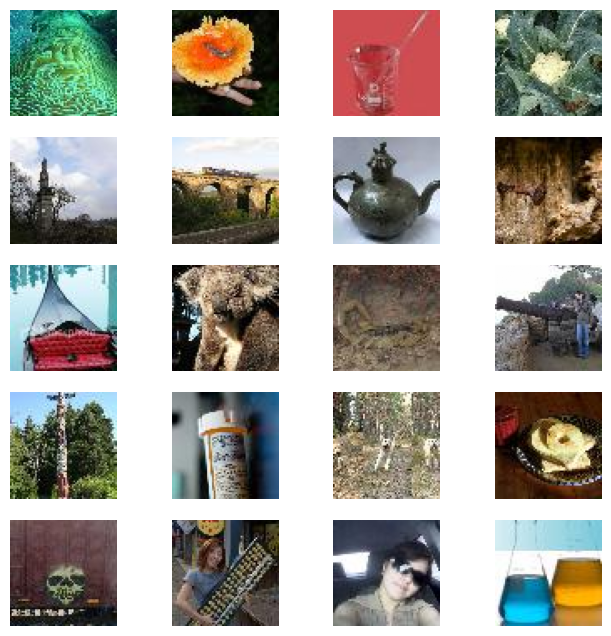

In [31]:
# Load the dataset
X_train_orig, X_test_orig = load_dataset_small()

# Normalize the image data
X_train = X_train_orig / 255.0
X_test = X_test_orig / 255.0

# Print dataset statistics
print("Number of training examples =", X_train.shape[0])
print("Number of test examples =", X_test.shape[0])
print("X_train shape:", X_train.shape)

# Display some sample images
fig = plt.figure(figsize=(8, 8))
columns, rows = 4, 5
for i in range(1, columns * rows + 1):
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(X_train[img_idx])
plt.show()

# Split the training dataset into two halves
input_S = X_train[:X_train.shape[0] // 2]
input_C = X_train[X_train.shape[0] // 2:]

# Loss functions
beta = 1.0

In [32]:
def rev_loss(s_true, s_pred):
    return beta * K.sum(K.square(s_true - s_pred))

def full_loss(y_true, y_pred):
    s_true, c_true = y_true[..., :3], y_true[..., 3:6]
    s_pred, c_pred = y_pred[..., :3], y_pred[..., 3:6]
    return rev_loss(s_true, s_pred) + K.sum(K.square(c_true - c_pred))

# Create the encoder
def make_encoder(input_size):
    input_S = Input(shape=input_size)
    input_C = Input(shape=input_size)

    # Preparation network
    x = concatenate([
        Conv2D(50, (3, 3), padding='same', activation='relu')(input_S),
        Conv2D(10, (4, 4), padding='same', activation='relu')(input_S),
        Conv2D(5, (5, 5), padding='same', activation='relu')(input_S),
    ])
    x = concatenate([
        Conv2D(50, (3, 3), padding='same', activation='relu')(x),
        Conv2D(10, (4, 4), padding='same', activation='relu')(x),
        Conv2D(5, (5, 5), padding='same', activation='relu')(x),
    ])

    # Combine with cover image
    x = concatenate([input_C, x])

    # Hiding network
    for _ in range(4):  # Repeated layers
        x = concatenate([
            Conv2D(50, (3, 3), padding='same', activation='relu')(x),
            Conv2D(10, (4, 4), padding='same', activation='relu')(x),
            Conv2D(5, (5, 5), padding='same', activation='relu')(x),
        ])
    output_Cprime = Conv2D(3, (3, 3), padding='same', activation='relu')(x)

    return Model([input_S, input_C], output_Cprime, name='Encoder')

# Create the decoder
def make_decoder(input_size):
    reveal_input = Input(shape=input_size)
    x = GaussianNoise(0.01)(reveal_input)  # Add noise

    for _ in range(4):  # Repeated layers
        x = concatenate([
            Conv2D(50, (3, 3), padding='same', activation='relu')(x),
            Conv2D(10, (4, 4), padding='same', activation='relu')(x),
            Conv2D(5, (5, 5), padding='same', activation='relu')(x),
        ])
    output_Sprime = Conv2D(3, (3, 3), padding='same', activation='relu')(x)

    return Model(reveal_input, output_Sprime, name='Decoder')

# Encoder and decoder creation
input_size = X_train.shape[1:]
encoder = make_encoder(input_size)
decoder = make_decoder(input_size)

print("Encoder summary:")
encoder.summary()

print("Decoder summary:")
decoder.summary()

Encoder summary:


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_160 (Conv2D) │ (None, 64, 64,    │      1,400 │ input_layer_23[0… │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_161 (Conv2D) │ (None, 64, 64,    │        490 │ input_layer_23[0… │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_162 (Conv2D) │ (None, 64, 64, 5) │        380 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_55      │ (None, 64, 64,    │          0 │ conv2d_160[0][0], │
│ (Concatenate)       │ 65)               │            │ conv2d_161[0][0], │
│                     │                   │            │ conv2d_162[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_163 (Conv2D) │ (None, 64, 64,    │     29,300 │ concatenate_55[0… │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_164 (Conv2D) │ (None, 64, 64,    │     10,410 │ concatenate_55[0… │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_165 (Conv2D) │ (None, 64, 64, 5) │      8,130 │ concatenate_55[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_24      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_56      │ (None, 64, 64,    │          0 │ conv2d_163[0][0], │
│ (Concatenate)       │ 65)               │            │ conv2d_164[0][0], │
│                     │                   │            │ conv2d_165[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_57      │ (None, 64, 64,    │          0 │ input_layer_24[0… │
│ (Concatenate)       │ 68)               │            │ concatenate_56[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_166 (Conv2D) │ (None, 64, 64,    │     30,650 │ concatenate_57[0… │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_167 (Conv2D) │ (None, 64, 64,    │     10,890 │ concatenate_57[0… │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_168 (Conv2D) │ (None, 64, 64, 5) │      8,505 │ concatenate_57[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_58      │ (None, 64, 64,    │          0 │ conv2d_166[0][0], │
│ (Concatenate)       │ 65)               │            │ conv2d_167[0][0], │
│                     │                   │            │ conv2d_168[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_169 (Conv2D) │ (None, 64, 64,    │     29,300 │ concatenate_58[0… │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_170 (Conv2D) │ (None, 64, 64,    │     10,410 │ concatenate_58[0

 Total params: 245,433 (958.72 KB)

 Trainable params: 245,433 (958.72 KB)

 Non-trainable params: 0 (0.00 B)

Decoder summary:


Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_5    │ (None, 64, 64, 3) │          0 │ input_layer_25[0… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_179 (Conv2D) │ (None, 64, 64,    │      1,400 │ gaussian_noise_5… │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_180 (Conv2D) │ (None, 64, 64,    │        490 │ gaussian_noise_5… │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_181 (Conv2D) │ (None, 64, 64, 5) │        380 │ gaussian_noise_5… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_62      │ (None, 64, 64,    │          0 │ conv2d_179[0][0], │
│ (Concatenate)       │ 65)               │            │ conv2d_180[0][0], │
│                     │                   │            │ conv2d_181[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_182 (Conv2D) │ (None, 64, 64,    │     29,300 │ concatenate_62[0… │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_183 (Conv2D) │ (None, 64, 64,    │     10,410 │ concatenate_62[0… │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_184 (Conv2D) │ (None, 64, 64, 5) │      8,130 │ concatenate_62[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_63      │ (None, 64, 64,    │          0 │ conv2d_182[0][0], │
│ (Concatenate)       │ 65)               │            │ conv2d_183[0][0], │
│                     │                   │            │ conv2d_184[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_185 (Conv2D) │ (None, 64, 64,    │     29,300 │ concatenate_63[0… │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_186 (Conv2D) │ (None, 64, 64,    │     10,410 │ concatenate_63[0… │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_187 (Conv2D) │ (None, 64, 64, 5) │      8,130 │ concatenate_63[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_64      │ (None, 64, 64,    │          0 │ conv2d_185[0][0], │
│ (Concatenate)       │ 65)               │            │ conv2d_186[0][0], │
│                     │                   │            │ conv2d_187[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 64, 64,    │     29,300 │ concatenate_64[0… │
│                     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 64, 64,    │     10,410 │ concatenate_64[0… │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 64, 64, 5) │      8,130 │ concatenate_64[0

 Total params: 147,548 (576.36 KB)

 Trainable params: 147,548 (576.36 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras import Input, Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D, concatenate, GaussianNoise

# Define the EarlyStoppingByAccuracy callback
class EarlyStoppingByAccuracy(Callback):
    def __init__(self, patience=7, threshold=0.001):
        """
        Custom callback to stop training when the last 'patience' accuracies are close (i.e., smaller than the threshold).
        
        Args:
        - patience: Number of epochs to wait before stopping (i.e., the number of previous accuracies to consider).
        - threshold: The minimum change in accuracy between the last 'patience' epochs for training to continue.
        """
        super(EarlyStoppingByAccuracy, self).__init__()
        self.patience = patience
        self.threshold = threshold
        self.acc_history = []

    def on_epoch_end(self, epoch, logs=None):
        # Store the accuracy for the current epoch
        accuracy = logs.get('accuracy')  # Assuming you're using 'accuracy' as the metric
        self.acc_history.append(accuracy)

        # Keep only the last 'patience' accuracy values
        if len(self.acc_history) > self.patience:
            self.acc_history.pop(0)
        
        # Check if the accuracy change is smaller than the threshold
        if len(self.acc_history) == self.patience:
            diff = np.abs(np.diff(self.acc_history))  # Compute absolute differences between consecutive accuracies
            if np.all(diff < self.threshold):  # If all differences are smaller than threshold, stop training
                print(f"\nStopping training early at epoch {epoch+1} as accuracy change is less than {self.threshold}")
                self.model.stop_training = True

In [37]:
# Define your model creation function (encoder + decoder)
def create_complete_model(input_size):
    encoder = make_encoder(input_size)
    decoder = make_decoder(input_size)

    # Encoder and decoder combined
    input_S = Input(shape=input_size)
    input_C = Input(shape=input_size)

    # Generate encoded output
    encoded = encoder([input_S, input_C])

    # Decode the encoded output to reveal the secret
    decoded = decoder(encoded)

    # Create the model
    model = Model([input_S, input_C], decoded, name='CompleteModel')

    # Compile the model with custom loss
    model.compile(optimizer='adam', loss=full_loss, metrics=['accuracy'])

    return model

input_size = X_train.shape[1:]

# Create the complete model
model = create_complete_model(input_size)

# Print model summary
model.summary()

# Define other callbacks
checkpoint = ModelCheckpoint("model.keras", monitor="loss", save_best_only=True)
tensorboard = TensorBoard(log_dir="./logs")

# Create the EarlyStoppingByAccuracy callback
early_stopping_callback = EarlyStoppingByAccuracy(patience=10, threshold=0.001)

# Train the model with the callbacks
history = model.fit(
    [X_train[:X_train.shape[0] // 2], X_train[X_train.shape[0] // 2:]],  # Use original training data
    X_train[:X_train.shape[0] // 2],  # We're trying to recover the secret S from the cover C
    epochs=150,
    batch_size=32,
    callbacks=[checkpoint, tensorboard, early_stopping_callback]  # Add early stopping callback here
)

Model: "CompleteModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_40      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder             │ (None, 64, 64, 3) │    245,433 │ input_layer_39[0… │
│ (Functional)        │                   │            │ input_layer_40[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (None, 64, 64, 3) │    147,548 │ Encoder[0][0]     │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 392,981 (1.50 MB)

 Trainable params: 392,981 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.3748 - loss: 93775.8672
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.4975 - loss: 10939.9521
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.5489 - loss: 7288.3813
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 121s 4s/step - accuracy: 0.5626 - loss: 7405.2471
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.5891 - loss: 5247.4395
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.6196 - loss: 4115.7319
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.6816 - loss: 2602.3364
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.6686 - loss: 2917.3738
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.6918 - loss: 1905.8912
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.6771 - loss: 2071.7070
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.7031 - loss: 1558.4916
Epoch 12/150
32/32 ━━━━━

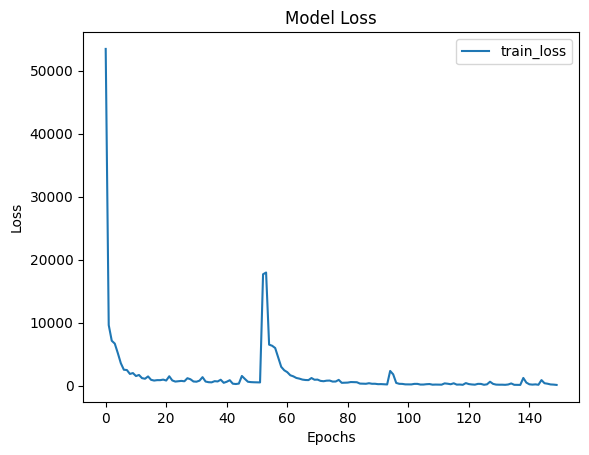

In [38]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
plot_loss(history)

In [39]:
# Assuming 'model' is your deep learning model
model.save('STEGANOGRAPHY_model.h5')
print("Model saved as 'steganography_model.h5'")


Model saved as 'steganography_model.h5'


In [41]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('STEGANOGRAPHY_model.h5', compile=False)

# Retrieve decoded predictions
decoded = loaded_model.predict([input_S, input_C])
print({decoded.shape})
decoded_S, decoded_C = decoded[..., 0:3], decoded[..., 3:6]

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step
{(1000, 64, 64, 3)}


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to calculate pixel errors
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images."""
    see_Spixel = np.sqrt(np.mean(np.square(255 * (input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255 * (input_C - decoded_C))))
    return see_Spixel, see_Cpixel

# Function to calculate pixel histogram of errors
def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image."""
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()

    fig = plt.figure(figsize=(15, 5))
    a = fig.add_subplot(1, 2, 1)
    plt.hist(255 * diff_Cflat, 100, density=True, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])

    a = fig.add_subplot(1, 2, 2)
    plt.hist(255 * diff_Sflat, 100, density=True, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])

    plt.show()


In [43]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# Function to show images with options for gray scale
def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap=plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

S error per pixel [0, 255]: 104.15362126073285
C error per pixel [0, 255]: 104.05878324243571


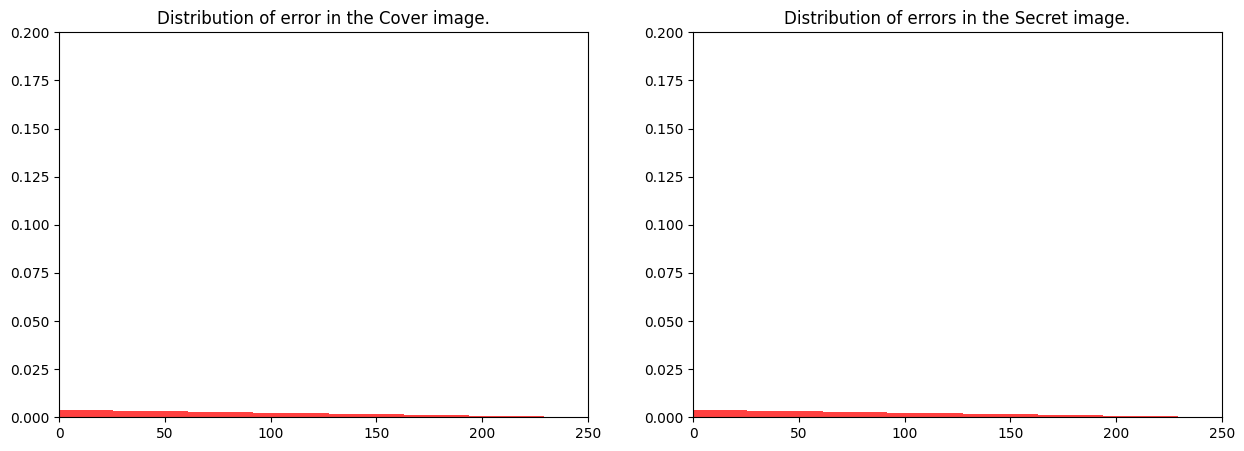

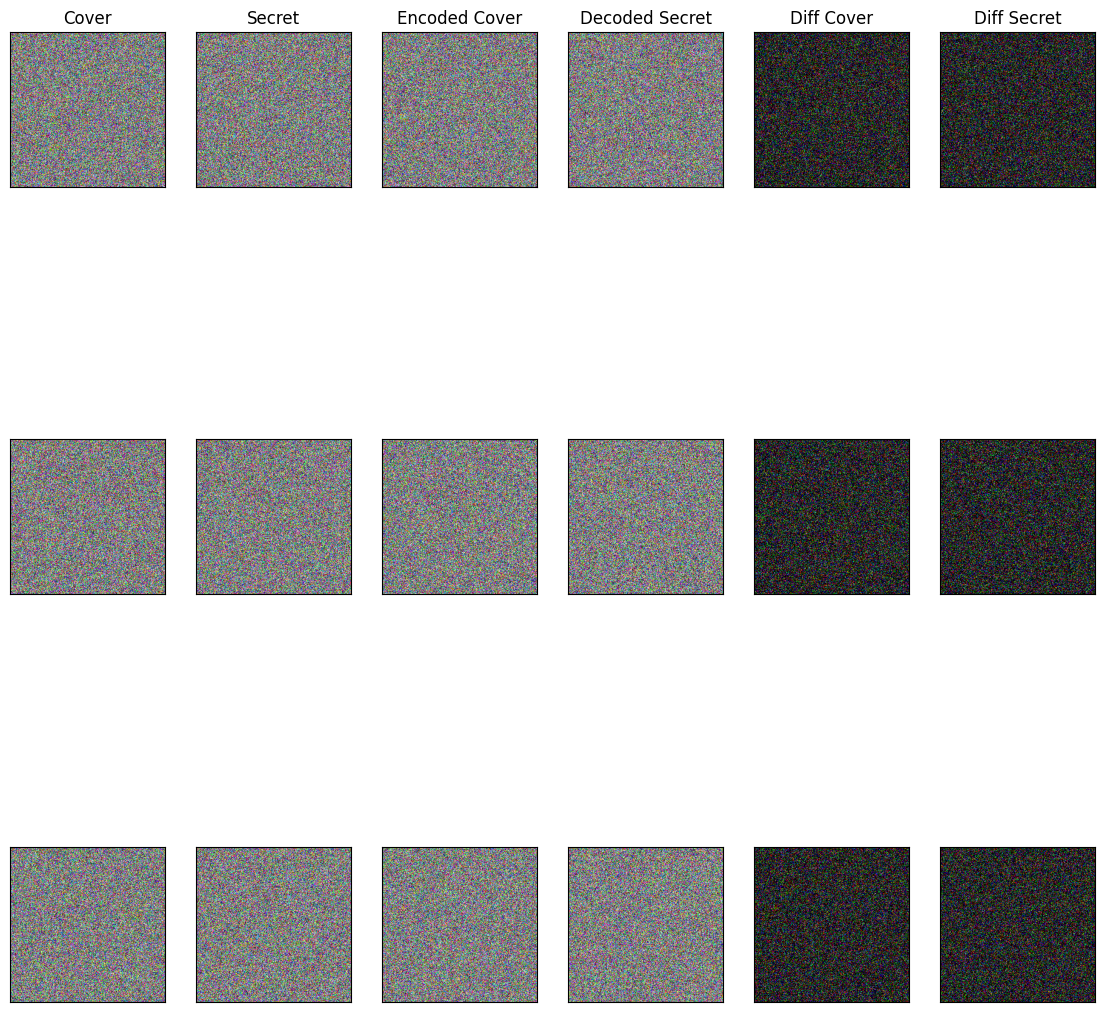

In [44]:

# Function to convert RGB to grayscale


# Example dataset
input_S = np.random.rand(10, 256, 256, 3)  # Example secret images
input_C = np.random.rand(10, 256, 256, 3)  # Example cover images
decoded_S = np.random.rand(10, 256, 256, 3)  # Decoded secret images
decoded_C = np.random.rand(10, 256, 256, 3)  # Decoded cover images
diff_S = decoded_S - input_S  # Difference between decoded and true secret
diff_C = decoded_C - input_C  # Difference between decoded and true cover

# Print pixel-wise average errors in a 256 scale
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)
print("S error per pixel [0, 255]:", S_error)
print("C error per pixel [0, 255]:", C_error)

# Show histograms of pixel errors
pixel_histogram(diff_S, diff_C)

# Visualize a subset of the dataset
plt.figure(figsize=(14, 15))
n = 3  # Number of random images to display
rand_indx = [random.randint(0, 9) for _ in range(n)]
SHOW_DIFF = True  # Set to True to show the diff images
SHOW_GRAY = False  # Set to True to display in grayscale
ENHANCE = 1  # Enhance diff images for visibility

for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4

    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i == 0, title='Cover')
    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i == 0, title='Secret')
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i == 0, title='Encoded Cover')
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i == 0, title='Decoded Secret')

    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i == 0, title='Diff Cover')
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i == 0, title='Diff Secret')

plt.show()




In [45]:
from IPython.display import FileLink

# Save model weights
model.save_weights('./model_weights_best.weights.h5')

# Provide a link to download the file
FileLink('./model_weights_best.weights.h5')


/jupyter/socse.user26/model_weights_best.weights.h5

In [46]:
# Assuming 'model' is your deep learning model
model.save('DEEP_STEGNOGRAPHY_model.h5')
print("Model saved as 'Deep_steganography_model.h5'")


Model saved as 'Deep_steganography_model.h5'
